In [ ]:
# Import dependencies
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Read in the cardiovascular dataset from Google Sheets
cvd_df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSDchXr1EhgCSsxlxJ3lWPhh1kT5EJS3yv4DJ2YLeMIC3y4uq-Pp4EQknrs9zAiaI3ulne2Jyi6gR6G/pub?gid=602879552&single=true&output=csv")
cvd_df.head()

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_cm,weight_kg,bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0


# Data Preprocessing

In [ ]:
# Check datatypes
cvd_df.dtypes

general_health                   object
checkup                          object
exercise                         object
heart_disease                    object
skin_cancer                      object
other_cancer                     object
depression                       object
diabetes                         object
arthritis                        object
sex                              object
age_category                     object
height_cm                         int64
weight_kg                       float64
bmi                             float64
smoking_history                  object
alcohol_consumption               int64
fruit_consumption                 int64
green_vegetables_consumption      int64
friedpotato_consumption           int64
dtype: object

In [ ]:
# Define categorical columns for encoding and numeric columns for scaling
categorical_cols = cvd_df.dtypes[cvd_df.dtypes == 'object'].index.tolist()

numeric_cols = cvd_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Check value counts of target variable
cvd_df['heart_disease'].value_counts()

No     275231
Yes     24081
Name: heart_disease, dtype: int64

The proportion of positive instances of heart disease ('Yes') to negative instances ('No') is heavily imbalanced. Initial testing revealed that this would result in a model that can accurately predict if a patient does not have heart diease, but is not able to accurately predict if a person does have disease. For this reason, we have decided to cut down the majority class, in this instance the 'No' category, to make the classes more balanced.

We have chosen to remove all datapoints that lay outside of 1 standard deviation from the mean of the data.

In [ ]:
# Calculate mean and standard deviation for numeric columns
means = cvd_df[numeric_cols].mean()
stds = cvd_df[numeric_cols].std()

# Define the number of standard deviations for the threshold
threshold_std = 1

# Identify outliers for numeric columns based on standard deviations
outliers = ((cvd_df[numeric_cols] - means).abs() > threshold_std * stds).any(axis=1)

# Filter rows where 'heart_disease' is 'No' and not an outlier
filtered_rows = (~outliers) | (cvd_df['heart_disease'] == 'Yes')

# Create the filtered DataFrame
cvd_df_filtered = cvd_df[filtered_rows]

In [ ]:
# Re-check value counts of target variable
cvd_df_filtered['heart_disease'].value_counts()

No     55566
Yes    24081
Name: heart_disease, dtype: int64

The classes in the target variable are now significantly closer to being balanced than previously.

In [ ]:
# Encode categorical columns using get_dummies
encoded_df = pd.get_dummies(cvd_df_filtered, columns=categorical_cols, drop_first=False)
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,165,77.11,28.29,0,30,0,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,180,93.44,28.73,0,30,30,8,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,175,69.85,22.74,0,16,8,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,163,72.57,27.46,0,12,12,4,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,163,91.63,34.67,0,12,12,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Scale numerical columns using StandardScaler
scaler = StandardScaler()
encoded_df[numeric_cols] = scaler.fit_transform(encoded_df[numeric_cols])
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,-0.832260,-0.393566,-0.000590,-0.556508,0.413674,-1.250370,-0.166917,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.184427,0.704890,0.095604,-0.556508,0.413674,1.515171,0.547281,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,0.512198,-0.881918,-1.213951,-0.556508,-0.472114,-0.512893,-0.881115,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,-1.101152,-0.698954,-0.182048,-0.556508,-0.725196,-0.144154,-0.166917,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,-1.101152,0.583139,1.394228,-0.556508,-0.725196,-0.144154,-0.702566,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Assign the target variable 'heart_disease' to y
y = encoded_df['heart_disease_Yes']

# Assign the remaining columns (features) to X
X = encoded_df.drop(columns=['heart_disease_Yes', 'heart_disease_No'])

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Checking the value counts of the y variable
y_train.value_counts()

0    41653
1    18082
Name: heart_disease_Yes, dtype: int64

In [ ]:
# Fit a random over sampler model to the training data to balance out the classes fully
ROS = RandomOverSampler(random_state=78)
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train)

In [ ]:
# Re-check the value counts to ensure oversampling has worked
y_train_resampled.value_counts()

1    41653
0    41653
Name: heart_disease_Yes, dtype: int64

# Model 1: Logistic Regression

# Model 2: Support Vector Machine

# Model 3: Decision Tree

In [ ]:
# Import additional depedencies

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Creating Decision Tree Classifier

clf = DecisionTreeClassifier(random_state=42)

In [ ]:
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Predicting on the test data
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8935315387705905
Confusion Matrix:
 [[12776  1137]
 [  983  5016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     13913
           1       0.82      0.84      0.83      5999

    accuracy                           0.89     19912
   macro avg       0.87      0.88      0.87     19912
weighted avg       0.89      0.89      0.89     19912



**OPTIMISATION 1**

In [ ]:
# Create a Decision Tree Classifier with custom hyperparameters
clf = DecisionTreeClassifier(
    random_state=42,  # for reproducibility
    max_depth=10,    # set the maximum depth of the tree (you can experiment with different values)
    min_samples_split=2,  # minimum samples required to split an internal node
    min_samples_leaf=1    # minimum number of samples required to be a leaf node
)

In [ ]:
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
# Predicting on the test data
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9283848935315387
Confusion Matrix:
 [[13913     0]
 [ 1426  4573]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13913
           1       1.00      0.76      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.95      0.88      0.91     19912
weighted avg       0.94      0.93      0.93     19912



**OPTIMISATION 2**

# Model 4: Random Forest

In [ ]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Fit the model to the training data
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Predicting on the test data
y_pred = rf.predict(X_test)

In [ ]:
# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9280333467255926
Confusion Matrix:
 [[13557   356]
 [ 1077  4922]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13913
           1       0.93      0.82      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.93      0.90      0.91     19912
weighted avg       0.93      0.93      0.93     19912



In [ ]:
# Calculate feature importance
feature_importance = rf.feature_importances_

In [ ]:
# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

In [ ]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Print or visualize the feature importance
print(importance_df)


                            Feature  Importance
0                         height_cm    0.168849
4                 fruit_consumption    0.155208
2                               bmi    0.103543
1                         weight_kg    0.102074
3               alcohol_consumption    0.069646
6           friedpotato_consumption    0.058505
5      green_vegetables_consumption    0.054695
27                     arthritis_No    0.020196
26                     diabetes_Yes    0.020141
43                 age_category_80+    0.019500
25                      diabetes_No    0.018765
8               general_health_Fair    0.018438
28                    arthritis_Yes    0.013832
10              general_health_Poor    0.012223
11         general_health_Very Good    0.011168
7          general_health_Excellent    0.010467
29                       sex_Female    0.010109
30                         sex_Male    0.009722
42               age_category_75-79    0.009370
44               smoking_history_No    0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Display only the top N most important features
top_n = 10  # Adjust the number of top features to display
top_importance_df = importance_df.head(top_n)


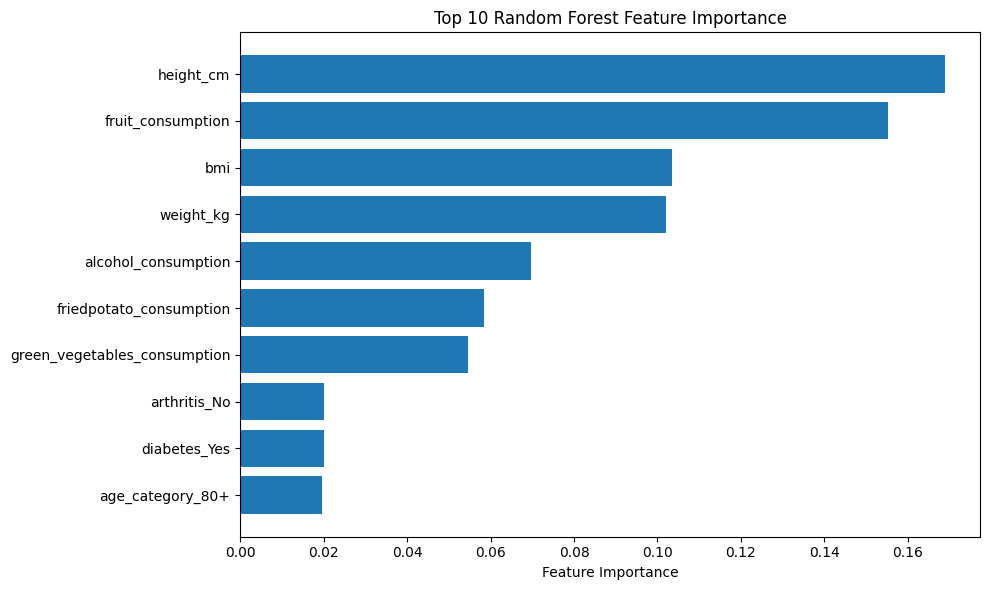

In [ ]:
# Plot the feature importance
y_pos = range(len(top_importance_df))
plt.figure(figsize=(10, 6))
plt.barh(y_pos, top_importance_df['Importance'])
plt.yticks(y_pos, top_importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top {} Random Forest Feature Importance'.format(top_n))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Model 5: Neural Network